In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
from sklearn.metrics import f1_score, log_loss, confusion_matrix, classification_report

from model_simple_rnn import *

In [3]:
# Use GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Available device: {}".format(device))
if use_cuda:
    print(torch.cuda.get_device_name(0))

Available device: cuda:0
NVIDIA GeForce GTX 1070


In [4]:
vocabulary_file_path = 'data/processed/vocabulary.vocab'
processed_train_dataset_file_path = 'data/processed/processed-data-train.txt'
processed_test_dataset_file_path = 'data/processed/processed-data-test.txt'

# vocabulary_file_path = 'data/processed/vocabulary2.vocab'
# processed_train_dataset_file_path = 'data/processed/processed-data-train2.txt'
# processed_test_dataset_file_path = 'data/processed/processed-data-test2.txt'

# Load the Vocabulary



In [5]:
vocabulary = load_vocabulary(vocabulary_file_path)
vocab_size = len(vocabulary)
print('Size of vocabulary:\t{}'.format(vocab_size))

Size of vocabulary:	10004


Text(0, 0.5, 'Length')

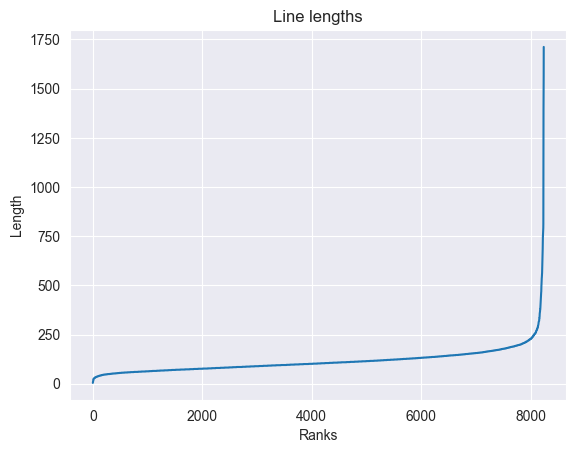

In [6]:
with open(processed_train_dataset_file_path) as file:
    line_lengths = [len(line) for line in file]
    
line_lengths = sorted(line_lengths)
ranks = list(range(len(line_lengths)))

plt.plot(ranks, line_lengths)

plt.title('Line lengths')
plt.xlabel('Ranks')
plt.ylabel('Length')

In [7]:
# max number of tokens: 1712
max(line_lengths)

1712

In [8]:
# Most samples have 256 tokens or fewer
# We will use this value for the maximum length of a sample
MAX_LENGTH = 256

counts = len([element for element in line_lengths if element > MAX_LENGTH])
print('There are {} ({:.3f}%) samples with more than {} tokens'.format(counts, 100*counts/len(line_lengths), MAX_LENGTH))


There are 152 (1.845%) samples with more than 256 tokens


# Load the Preprocessed Train and Test Data

In [9]:
# Load the dataset
samples_train = load_dataset(processed_train_dataset_file_path, MAX_SEQ_LEN)
samples_test = load_dataset(processed_test_dataset_file_path, MAX_SEQ_LEN)

# shuffle the dataset
random.shuffle(samples_train)
random.shuffle(samples_test)
        
print('Number of training samples: {}'.format(len(samples_train)))
print('Number of test samples: {}'.format(len(samples_test)))


Number of training samples: 8240
Number of test samples: 1857


In [10]:
samples_train[0]

([736,
  47,
  6,
  20,
  81,
  3497,
  13,
  4977,
  57,
  4,
  10,
  2359,
  1037,
  57,
  15,
  5,
  294,
  4,
  7],
 1)

In [11]:
# structure the data as a lists of samples and list of labels
# convert the data into tensors
X_train = [ torch.LongTensor(seq) for (seq, _) in samples_train ]
X_test  = [ torch.LongTensor(seq) for (seq, _) in samples_test ]

y_train = [ label for (_, label) in samples_train ]
y_test  = [ label for (_, label) in samples_test ]

y_train = torch.LongTensor(y_train)
y_test  = torch.LongTensor(y_test)

# Data Loaders

In [12]:
"""
Here we enforce that for every batch, each sample will be of the same length.
Output batch size is likely < 256.
Convenient ??

todo:   implement 0 padding for batches
        implement model to ignore 0 padding during training and evaluation
"""

# batch size -> 256

dataset_train = BasicDataset(X_train, y_train)
sampler_train = EqualLengthsBatchSampler(BATCH_SIZE, X_train, y_train)
loader_train = DataLoader(dataset_train, batch_sampler=sampler_train, shuffle=False, drop_last=False)

dataset_test = BasicDataset(X_test, y_test)
sampler_test = EqualLengthsBatchSampler(BATCH_SIZE, X_test, y_test)
loader_test = DataLoader(dataset_test, batch_sampler=sampler_test, shuffle=False, drop_last=False)

In [13]:
for X, y in loader_train:
    print('X.shape:', X.shape)
    print('y.shape:', y.shape)
    break

X.shape: torch.Size([11, 73])
y.shape: torch.Size([11])


# Model

Simple RNN Text Classifier

In [14]:
# Model Parameters
params = {
    "vocab_size": vocab_size,           # size of vocabulary
    "embed_size": 300,                  # 300 if using pretrained embeddings
    "rnn_cell": "LSTM",                  # RNN, GRU or LSTM

    "rnn_num_layers": 2,                # number of rnn layers
    "rnn_bidirectional": True,          # go over each sequence from both directions

    "rnn_hidden_size": 512,             # size of the RNN hidden state
    "rnn_dropout": 0.5,                 # dropout for rnn layers

    "linear_hidden_sizes": [128, 64],   # list of sizes of hidden linear layers
    "linear_dropout": 0.5,              # dropout for linear layers

    "output_size": 3                    # number of output classes
}
params = Dict2Class(params)

In [15]:
# Create model
rnn = RnnTextClassifier(params).to(device)
# Define optimizer
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.0002)

'''
Since we have samples of different length and we are also not using padding, resampling is difficult. We will use weighted loss functions during training to handle imbalance dataset.
'''
# Define loss function
class_weights = torch.tensor([1 / 4840, 1 / 2293, 1 / 1109]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
# criterion = nn.CrossEntropyLoss()

In [16]:
# Print the model
print(rnn)

RnnTextClassifier(
  (embedding): Embedding(10004, 300)
  (rnn): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (linears): ModuleList(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (out): Linear(in_features=64, out_features=3, bias=True)
)


# Pretrained word embeddings

Is it worth it?

pretrained word embeddings require embedding size of 300 which is very large.


In [17]:
# download pretrained word embeddings
# 'http://vectors.nlpl.eu/repository/20/5.zip'

In [18]:
# Use pretrained word embeddings
if is_pretrained_embeddings and params.embed_size == 300:
    print("Using Pretrained Embeddings")
    pretrained_vectors = torchtext.vocab.Vectors("data/embeddings/model.txt")
    pretrained_embedding = pretrained_vectors.get_vecs_by_tokens(vocabulary.get_itos())
    rnn.embedding.weight.data = pretrained_embedding

# True -> embedding layer can be trained (not fixed)
rnn.embedding.weight.requires_grad = False
rnn.to(device)

Using Pretrained Embeddings


RnnTextClassifier(
  (embedding): Embedding(10004, 300)
  (rnn): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (linears): ModuleList(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (out): Linear(in_features=64, out_features=3, bias=True)
)

# Training

In [19]:
# Testing on an untrained model
f1_test = evaluate(rnn, loader_test, device)
print('F1 score for untrained model: {:.3f}'.format(f1_test))

  0%|          | 0/1857 [00:00<?, ?it/s]

torch.Size([4, 64])


  0%|          | 0/1857 [00:00<?, ?it/s]

torch.Size([4, 64, 300])
torch.Size([4, 4, 512])


NameError: name 'exit' is not defined

In [ ]:
num_epochs = 30

results = train(rnn, loader_train, loader_test, optimizer, criterion, num_epochs, device, verbose=True)

In [ ]:
f1_test = evaluate(rnn, loader_test, device)

print('F1 score for trained model: {:.3f}'.format(f1_test))

In [ ]:
def plot_training_results(results):
    
    x = list(range(1, len(results)+1))
    
    losses = [ tup[0] for tup in results ]
    acc_train = [ tup[1] for tup in results ]
    acc_test = [ tup[2] for tup in results ]

    losses = np.asarray(losses)
    losses = losses/np.max(losses)

    plt.figure()

    plt.plot(x, losses)
    plt.plot(x, acc_train)
    plt.plot(x, acc_test)

    font_axes = {'family':'serif','color':'black','size':16}

    plt.xlabel("Epoch", fontdict=font_axes)
    plt.ylabel("F1 Score", fontdict=font_axes)
    plt.legend(['Loss', 'F1 (train)', 'F1 (test)'], loc='lower left', fontsize=12)
    plt.tight_layout()
    plt.show()

In [ ]:
# Best score
plot_training_results(results)

In [ ]:
# [Epoch 6] loss: 15.440, f1 train: 0.891, f1 test: 0.774
model_path = 'model/rnn/rnn_model_lstm_v1.pth'

vocabulary_file_path = 'data/processed/vocabulary.vocab'
processed_test_dataset_file_path = 'data/processed/processed-data-test.txt'

vocabulary = load_vocabulary(vocabulary_file_path)
vocab_size = len(vocabulary)
print('Size of vocabulary:\t{}'.format(vocab_size))

samples_test = load_dataset(processed_test_dataset_file_path, MAX_SEQ_LEN)

X_test  = [ torch.LongTensor(seq) for (seq, _) in samples_test ]
y_test  = [ label for (_, label) in samples_test ]
y_test  = torch.LongTensor(y_test)

dataset_test = BasicDataset(X_test, y_test)
sampler_test = EqualLengthsBatchSampler(BATCH_SIZE, X_test, y_test)
loader_test = DataLoader(dataset_test, batch_sampler=sampler_test, shuffle=False, drop_last=False)

# Model Parameters
eval_model_params = {
    "vocab_size": vocab_size,           # size of vocabulary
    "embed_size": 300,                  # 300 if using pretrained embeddings
    "rnn_cell": "LSTM",                  # RNN, GRU or LSTM

    "rnn_num_layers": 2,                # number of rnn layers
    "rnn_bidirectional": True,          # go over each sequence from both directions

    "rnn_hidden_size": 512,             # size of the RNN hidden state
    "rnn_dropout": 0.5,                 # dropout for rnn layers

    "linear_hidden_sizes": [128, 64],   # list of sizes of hidden linear layers
    "linear_dropout": 0.5,              # dropout for linear layers

    "output_size": 3                    # number of output classes
}
eval_model_params = Dict2Class(eval_model_params)

eval_model = RnnTextClassifier(eval_model_params).to(device)

eval_model.load_state_dict(torch.load(model_path))
eval_model.eval()

y_true, y_pred = evaluate(eval_model, loader_test, device, is_f1=False)
label_list = ['background', 'method', 'result']

f1_eval = f1_score(y_true, y_pred, average='macro')
cm_eval = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=label_list)

print('Evaluating model: {}'.format(model_path))
print('F1 score for model: {:.3f}'.format(f1_eval))

sns.heatmap(cm_eval, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(report)

In [ ]:
# [Epoch 37] loss:	22.813, f1 train: 0.878, f1 test: 0.773
model_path = 'model/rnn/rnn_model_v1.pth'

vocabulary_file_path = 'data/processed/vocabulary.vocab'
processed_test_dataset_file_path = 'data/processed/processed-data-test.txt'

vocabulary = load_vocabulary(vocabulary_file_path)
vocab_size = len(vocabulary)
print('Size of vocabulary:\t{}'.format(vocab_size))

samples_test = load_dataset(processed_test_dataset_file_path, MAX_SEQ_LEN)

X_test  = [ torch.LongTensor(seq) for (seq, _) in samples_test ]
y_test  = [ label for (_, label) in samples_test ]
y_test  = torch.LongTensor(y_test)

dataset_test = BasicDataset(X_test, y_test)
sampler_test = EqualLengthsBatchSampler(BATCH_SIZE, X_test, y_test)
loader_test = DataLoader(dataset_test, batch_sampler=sampler_test, shuffle=False, drop_last=False)

# Model Parameters
eval_model_params = {
    "vocab_size": vocab_size,           # size of vocabulary
    "embed_size": 300,                  # 300 if using pretrained embeddings
    "rnn_cell": "GRU",                  # RNN, GRU or LSTM

    "rnn_num_layers": 2,                # number of rnn layers
    "rnn_bidirectional": True,          # go over each sequence from both directions

    "rnn_hidden_size": 512,             # size of the RNN hidden state
    "rnn_dropout": 0.5,                 # dropout for rnn layers

    "linear_hidden_sizes": [128, 64],   # list of sizes of hidden linear layers
    "linear_dropout": 0.5,              # dropout for linear layers

    "output_size": 3                    # number of output classes
}
eval_model_params = Dict2Class(eval_model_params)

eval_model = RnnTextClassifier(eval_model_params).to(device)

eval_model.load_state_dict(torch.load(model_path))
eval_model.eval()

y_true, y_pred = evaluate(eval_model, loader_test, device, is_f1=False)
label_list = ['background', 'method', 'result']

f1_eval = f1_score(y_true, y_pred, average='macro')
cm_eval = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=label_list)

print('Evaluating model: {}'.format(model_path))
print('F1 score for model: {:.3f}'.format(f1_eval))

sns.heatmap(cm_eval, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(report)